In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
!wget -q https://github.com/IntrotoML9103/Project/raw/main/final_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/art-dataset/releases/latest/download/imgs.tar.gz | tar xz


In [12]:
!ls

data_utils.py	 data_utils.py.3   final_utils.py.2  image_utils.py.1  imgs
data_utils.py.1  final_utils.py    final_utils.py.3  image_utils.py.2  __pycache__
data_utils.py.2  final_utils.py.1  image_utils.py    image_utils.py.3  sample_data


In [13]:
!unzip -q imgs.zip

unzip:  cannot find or open imgs.zip, imgs.zip.zip or imgs.zip.ZIP.


In [14]:
!rm -rf __MACOSX/

In [2]:
import torch

from torch import nn
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.transforms import v2
from torchvision.utils import make_grid

from data_utils import classification_error, display_confusion_matrix
from image_utils import make_image

from final_utils import LFWUtils

from unicodedata import normalize

Data Processing

In [3]:
import os
import random
from os import listdir, path
import torch
from torch import Tensor
from image_utils import make_image, open_image


random.seed(42)

artist_names = [
    "Albrecht_Durer",
    "Alfred_Sisley",
    "Amedeo_Modigliani",
    "Andy_Warhol",
    "Diego_Velazquez",
    "Edgar_Degas",
    "Francisco_Goya",
    "Frida_Kahlo",
    "Giotto_di_Bondone",
    "Gustav_Klimt",
    "Henri_Matisse",
    "Hieronymus_Bosch",
    "Joan_Miro",
    "Kazimir_Malevich",
    "Leonardo_da_Vinci",
    "Marc_Chagall",
    "Mikhail_Vrubel",
    "Pablo_Picasso",
    "Paul_Gauguin",
    "Paul_Klee",
    "Peter_Paul_Rubens",
    "Pierre-Auguste_Renoir",
    "Pieter_Bruegel",
    "Raphael",
    "Rembrandt",
    "Rene_Magritte",
    "Salvador_Dali",
    "Sandro_Botticelli",
    "Titian",
    "Vincent_van_Gogh"
]

artists_dict = {name:index  for index, name in enumerate(artist_names)}

file_names = sorted([normalize('NFC', f) for f in listdir("imgs") if f.endswith(".jpg")])

print(len(file_names))

random.shuffle(file_names)

train_files = file_names[:1000]
test_files = file_names[2727:]
check_files = file_names[151:200]

print(len(train_files))
print(len(test_files))

image_dir = "imgs"
new_size = (224, 224)

train_list = []
train_label = [] # get name from file - artists_dict map the name to the number - e.g: index Durer - returns 0


test_list = []
test_label = []

check_list = []
check_label = []

count = 0;

for fname in train_files:
    a_name = "_".join(fname.split("_")[:-1]).replace("ü", "u")
    label_1 = artists_dict.get(a_name, -1)

    if label_1 == -1:
      print("-1 is here")

    img_space = path.join(image_dir, fname)
    new_img = open_image(img_space).resize(new_size)
    img_tr = Tensor(new_img.pixels).reshape(224,224,-1).permute(2,0,1)
    if img_tr.shape[0] == 1:
        img_tr = img_tr.repeat(3,1,1)

    train_list.append(img_tr)
    train_label.append(label_1)

3030
1000
303


In [4]:
for fname in test_files:
    a_name = "_".join(fname.split("_")[:-1])
    label = artists_dict.get(a_name, -1)

    if label != -1:
        img_space = path.join(image_dir, fname)
        new_img = open_image(img_space).resize(new_size)
        img_t = Tensor(new_img.pixels).reshape(224,224,-1).permute(2,0,1)
        if img_t.shape[0] == 1:
            img_t = img_t.repeat(3,1,1)

    test_list.append(img_t)
    test_label.append(label)

In [14]:
from torch.utils.data import Dataset, DataLoader

x_train = torch.stack(train_list)
y_train = Tensor(train_label).long()

x_test = torch.stack(test_list)
y_test = Tensor(test_label).long()

mdevice = "cuda" if torch.cuda.is_available() else "cpu"

class FaceDataset(Dataset):
  def __init__(self, imgs, labels):
    self.imgs = imgs.to(mdevice)
    self.labels = labels.to(mdevice)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return [self.imgs[idx], self.labels[idx]]


train_dataloader = DataLoader(FaceDataset(x_train, y_train), batch_size=128) #shuffle=True)
test_dataloader = DataLoader(FaceDataset(x_test, y_test), batch_size=512)

In [15]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
display(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
train_transforms = v2.Compose([
	v2.RandomHorizontalFlip(p=0.5),
	v2.RandomRotation(degrees=15),
	v2.RandomPerspective(distortion_scale=0.15, p=0.5),
])

eval_transforms = v2.Compose([
  v2.Resize(224),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


torch.Size([128, 3, 224, 224]) torch.Size([3, 224, 224])


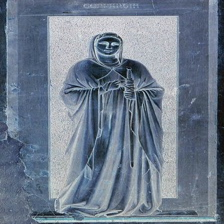

In [17]:
img,label = next(iter(train_dataloader))
print(img.shape, img[0].shape)
display(v2.ToPILImage()(img[0]))


In [18]:

model.fc = nn.Linear(model.fc.in_features, len(artist_names))
model = model.to(mdevice)

learning_rate = 5e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

img, label = next(iter(train_dataloader))
out = model(img.to(mdevice))

print("Input shape:", img.shape)
print("Output shape:", out.shape)
#print("Parameters:", len(artist_name))

Input shape: torch.Size([128, 3, 224, 224])
Output shape: torch.Size([128, 30])


In [19]:
for e in range(16):
  model.train()
  for img, labels in train_dataloader:
    optim.zero_grad()
    labels_pred = model(img.to(mdevice))
    loss = loss_fn(labels_pred, labels.to(mdevice))
    loss.backward()
    optim.step()

  if e % 4 == 3:
    print(f"Epoch: {e} loss: {loss.item():.4f}")

Epoch: 3 loss: 0.7132
Epoch: 7 loss: 0.0781
Epoch: 11 loss: 0.0296
Epoch: 15 loss: 0.0185


train error: 0.0000, test error: 0.4488


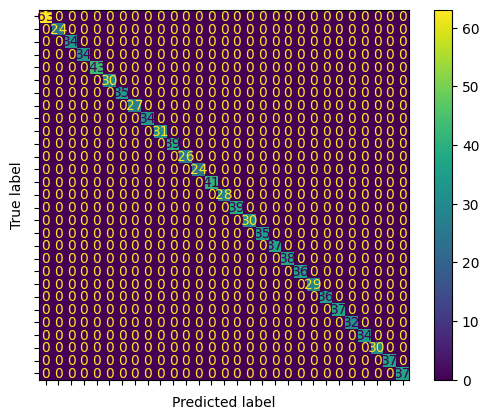

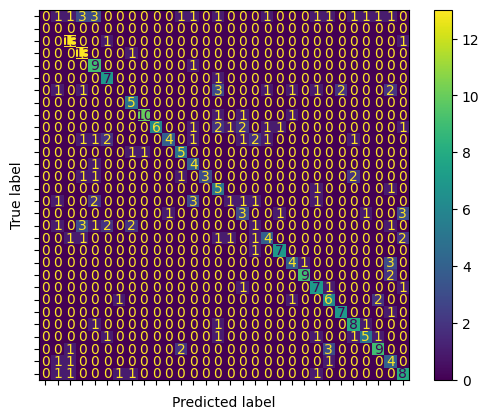

In [20]:
train_labels, train_predictions = LFWUtils.get_labels(model, train_dataloader)
test_labels, test_predictions = LFWUtils.get_labels(model, test_dataloader)
train_error = classification_error(train_labels, train_predictions)
test_error = classification_error(test_labels, test_predictions)
print(f"train error: {train_error:.4f}, test error: {test_error:.4f}")

display_confusion_matrix(train_labels, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(test_labels, test_predictions, display_labels=LFWUtils.LABELS)